<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Test/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [532]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import itertools

In this laboration, we will use DoE to maximize the yield of a catalytic reaction. Earlier Multivariate analysis has revealed the main components affecting the reaction rate is the concentration of the reactants c and the temperature T. Previous optimization efforts using the "one variable at the time" (OVAT) approach resulted in the current process conditions: c=1.9mM, T=30.1 oC which results in a reaction rate of 4.46 mole/s. Management has however doubts regarding the previous optimization team and wants to see increased profit, and has therefore hired you to increase the reaction rate. There is however one problem; running experiments is very expensive since it requires the shutdown of the whole plant.

In [703]:
def run_experiment(i,j, pars=None, add_noise=False):
    # to be changed: genereate all data here
    X=[i,j]
    np.random.seed(2)
    if not pars:
        x0 = np.random.randn(1)[0]*15+45.5
        y0 = np.random.randn(1)[0]+4.0
        fwhm = np.random.normal(loc=7.5,scale=5, size=100).mean()
    else:
        x0, y0, fwhm = pars

    func = 10*np.exp(-6*np.log(6) * (0.02*(X[0]-x0)**2 + (X[1]-y0)**2) / fwhm**2) + 5*np.exp(-4*np.log(2) * (0.01*(X[0]-x0-7)**2 + (X[1]-y0+2)**2) / fwhm**2) #+ 5*np.exp(-4*np.log(2) * (0.008*(X[0]-x0+7)**2 + (X[1]-y+2)**2) / fwhm**2)
#    func = 10*np.exp(-4*np.log(2) * ((X[0]-x0)**2 + (X[1]-y0)**2) / fwhm**2) + 5*np.exp(-4*np.log(2) * ((X[0]-x0+7)**2 + (X[1]-y0+2)**2) / fwhm**2) + 7*np.exp(-4*np.log(2) * ((X[0]-x0+5)**2 + (X[1]-y0+3)**2) / fwhm**2)
    if add_noise:
        func = add_noise_func(func)

    return func

def add_noise_func(input_data, mean_noise=0.0):
    # incomplete: refactor code to generate data + noise in one function
    import time
    time.sleep(5)
    np.random.seed(int(time.time()))
    avg_data = np.mean(input_data)
    noise_ = np.random.normal(mean_noise, np.sqrt(avg_data), 1)[0]/20
    output_data = input_data + noise_
    return output_data

5.773091243825593


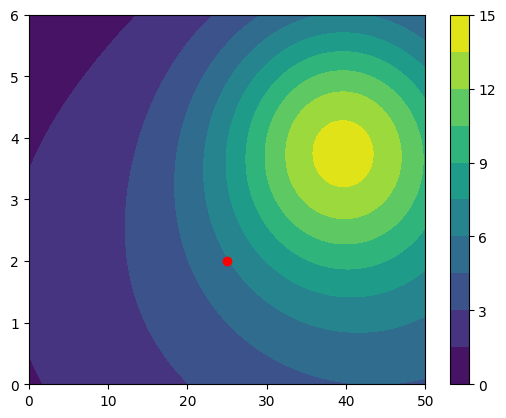

In [704]:
x_t = np.round(np.linspace(0,50,101),2)
y_t = np.round(np.linspace(0,6,101),2)
X, Y = np.meshgrid(x_t,y_t)
Z = run_experiment(X,Y, add_noise=True)
plt.contourf(x_t,y_t,Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(25, 2, color='r')
print(run_experiment(25,2, add_noise=True))


In [705]:
def encode(inputs_df):
    inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
    inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)
    inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
    inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)
    inputs_df = inputs_df.drop(['average','span'],axis=1)
    return inputs_df


def iterate(inputs_df):
    le=len(inputs_df.index.tolist())
    if le==2:
        encoded_inputs= list(itertools.product([inputs_df.encoded_low.x, inputs_df.encoded_high.x],[inputs_df.encoded_low.y,inputs_df.encoded_high.y]))
    if set(['center']).issubset(inputs_df.columns):
        for i in range(0,3):
            encoded_inputs.append((0,0))
            encoded_inputs
    return encoded_inputs

def real_experiment(encoded_df, inputs_df):
    real_exp = encoded_df
    var_labels = []
    for var in inputs_df.index.tolist():
        var_label = inputs_df.loc[var]['label']
        var_labels.append(var_label)
        if set(['center']).issubset(inputs_df.columns):
            real_exp[var_label] = encoded_df.apply(lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']),axis=1)
        else:
            real_exp[var_label] = encoded_df.apply(lambda z : inputs_df.loc[var]['low'] if z[var]<0 else inputs_df.loc[var]['high'], axis=1)

    return real_exp[var_labels]


# Setting up the DoE with full factorial design.

In [706]:
inputs_labels = {'x' : 'Temperature',
                 'y' : 'Concentration'}


# DOE1
xmin=35
xmax=40
ymin=1.0
ymax=1.5

dat = [('x',xmin,xmax),
       ('y',ymin,ymax)]

inputs_doe1_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_doe1_df = inputs_doe1_df.set_index(['index'])
inputs_doe1_df['label'] = inputs_doe1_df.index.map( lambda z : inputs_labels[z] )

inputs_doe1_df

,low,high,label
index,,,
x,35.0,40.0,Temperature
y,1.0,1.5,Concentration


In [707]:
inputs_doe1_df=encode(inputs_doe1_df)
encoded_inputs=iterate(inputs_doe1_df)
encoded_df=pd.DataFrame(encoded_inputs, columns=inputs_doe1_df.index.tolist())

In [708]:
real_doe1_df=real_experiment(encoded_df, inputs_doe1_df)
print("The values of each real variable in the experiment:")
real_doe1_df

The values of each real variable in the experiment:


,Temperature,Concentration
0,35.0,1.0
1,35.0,1.5
2,40.0,1.0
3,40.0,1.5


# Performing the experiments

In [709]:
resp=[]
results_doe1=encoded_df
for i in range(len(real_doe1_df)):
  resp.append(run_experiment(real_doe1_df['Temperature'][i],real_doe1_df['Concentration'][i]))

results_doe1['Response']=resp
results_doe1

,x,y,Temperature,Concentration,Response
0,-1.0,-1.0,35.0,1.0,5.883025
1,-1.0,1.0,35.0,1.5,7.185303
2,1.0,-1.0,40.0,1.0,6.215383
3,1.0,1.0,40.0,1.5,7.614118


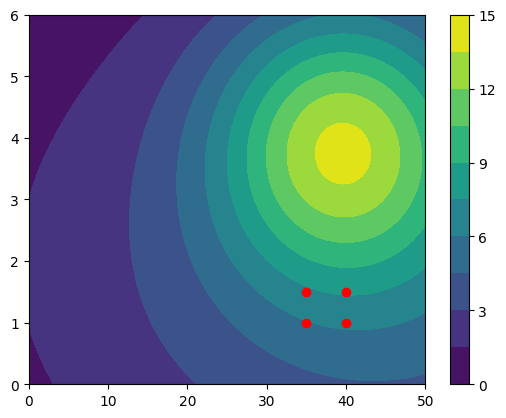

In [696]:
plt.contourf(x_t, y_t, Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(results_doe1.Temperature,results_doe1.Concentration, c='r')

# fit linear model

In [710]:
y1 = results_doe1['Response']
xlabs=['x','y']
x = results_doe1[xlabs]


res1 = smf.ols(formula='Response ~ x + y', data=results_doe1).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     423.2
Date:                Mon, 07 Oct 2024   Prob (F-statistic):             0.0344
Time:                        12:45:53   Log-Likelihood:                 9.2241
No. Observations:                   4   AIC:                            -12.45
Df Residuals:                       1   BIC:                            -14.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7245      0.024    278.858      0.002       6.418       7.031
x              0.1903      0.024      7.891      0.080      -0.116       0.497
y              0.6753      0.024     28.002      0.023       0.369       0.982
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.667
Skew:                           0.000   Prob(JB):                        0.717
Kurtosis:                       1.000   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Temperature is more significant, still we assume a linear model and follow the gradient. one step in x corresponds to  0.0241/1.9523 steps in y. Let's move in that direction and make a new box

# Second try
Assume a centerpoint at 37 which --> 1.9+0.0241/1.9523*5

In [698]:
1.9+0.0241/1.9523*5

1.9617220714029606

In [711]:
inputs_labels = {'x' : 'Temperature',
                 'y' : 'Concentration'}

xmin=35
xmax=40
ymin=2.5
ymax=3.0

dat = [('x',xmin,(xmin+xmax)/2,xmax),
       ('y',ymin,(ymin+ymax)/2,ymax)]

inputs_doe2_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_doe2_df = inputs_doe2_df.set_index(['index'])
inputs_doe2_df['label'] = inputs_doe2_df.index.map( lambda z : inputs_labels[z] )

inputs_doe2_df

,low,center,high,label
index,,,,
x,35.0,37.50,40.0,Temperature
y,2.5,2.75,3.0,Concentration


In [712]:
inputs_doe2_df=encode(inputs_doe2_df)
encoded_inputs=iterate(inputs_doe2_df)
encoded_df=pd.DataFrame(encoded_inputs, columns=inputs_doe2_df.index.tolist())

In [713]:
real_doe2_df=real_experiment(encoded_df, inputs_doe2_df)
print("The values of each real variable in the experiment:")
real_doe2_df

The values of each real variable in the experiment:


,Temperature,Concentration
0,35.0,2.50
1,35.0,3.00
2,40.0,2.50
3,40.0,3.00
4,37.5,2.75
5,37.5,2.75
6,37.5,2.75


In [714]:
resp=[]
results_doe2=encoded_df
for i in range(len(real_doe2_df)):
  resp.append(run_experiment(real_doe2_df['Temperature'][i],real_doe2_df['Concentration'][i], add_noise=True))

results_doe2['Response']=resp
results_doe2

,x,y,Temperature,Concentration,Response
0,-1.0,-1.0,35.0,2.50,10.713004
1,-1.0,1.0,35.0,3.00,11.944992
2,1.0,-1.0,40.0,2.50,11.046021
3,1.0,1.0,40.0,3.00,13.245389
4,0.0,0.0,37.5,2.75,11.654998
5,0.0,0.0,37.5,2.75,11.812871
6,0.0,0.0,37.5,2.75,11.817553


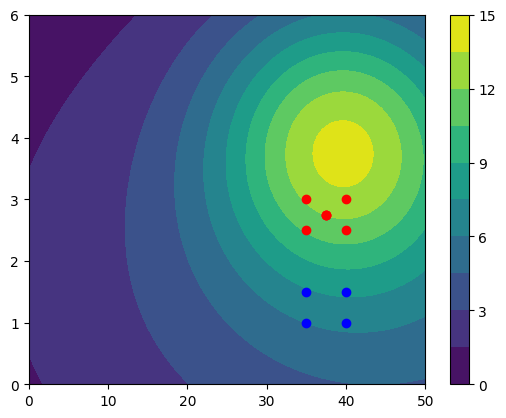

In [715]:
plt.contourf(x_t, y_t, Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(results_doe1.Temperature,results_doe1.Concentration, c='b')
plt.scatter(results_doe2.Temperature,results_doe2.Concentration, c='r')

In [716]:
y1 = results_doe2['Response']
xlabs=['x','y']
x = results_doe2[xlabs]


res1 = smf.ols(formula='Response ~ x + y', data=results_doe2).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     28.64
Date:                Mon, 07 Oct 2024   Prob (F-statistic):            0.00426
Time:                        12:47:01   Log-Likelihood:                 1.7008
No. Observations:                   7   AIC:                             2.598
Df Residuals:                       4   BIC:                             2.436
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7478      0.095    123.807      0.000      11.484      12.011
x              0.4084      0.126      3.253      0.031       0.060       0.757
y              0.8578      0.126      6.834      0.002       0.509       1.206
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.372
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.653
Skew:                          -0.158   Prob(JB):                        0.721
Kurtosis:                       1.537   Cond. No.                         1.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Still temperature matter

# Third Try

In [717]:
inputs_labels = {'x' : 'Temperature',
                 'y' : 'Concentration'}

xmin=38
xmax=42
ymin=3.8
ymax=4.2

dat = [('x',xmin,(xmin+xmax)/2,xmax),
       ('y',ymin,(ymin+ymax)/2,ymax)]

inputs_doe3_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_doe3_df = inputs_doe3_df.set_index(['index'])
inputs_doe3_df['label'] = inputs_doe3_df.index.map( lambda z : inputs_labels[z] )



inputs_doe3_df=encode(inputs_doe3_df)
encoded_inputs=iterate(inputs_doe3_df)
encoded_df=pd.DataFrame(encoded_inputs, columns=inputs_doe3_df.index.tolist())

real_doe3_df=real_experiment(encoded_df, inputs_doe3_df)
print("The values of each real variable in the experiment:")
real_doe3_df

The values of each real variable in the experiment:


,Temperature,Concentration
0,38.0,3.8
1,38.0,4.2
2,42.0,3.8
3,42.0,4.2
4,40.0,4.0
5,40.0,4.0
6,40.0,4.0


In [718]:
resp=[]
results_doe3=encoded_df
for i in range(len(real_doe3_df)):
  resp.append(run_experiment(real_doe3_df['Temperature'][i],real_doe3_df['Concentration'][i]))

results_doe3['Response']=resp
results_doe3

,x,y,Temperature,Concentration,Response
0,-1.0,-1.0,38.0,3.8,13.869831
1,-1.0,1.0,38.0,4.2,13.428919
2,1.0,-1.0,42.0,3.8,13.729787
3,1.0,1.0,42.0,4.2,13.281598
4,0.0,0.0,40.0,4.0,13.842480
5,0.0,0.0,40.0,4.0,13.842480
6,0.0,0.0,40.0,4.0,13.842480


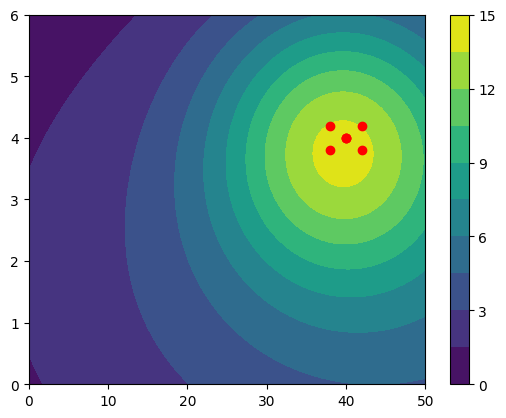

In [719]:
plt.contourf(x_t, y_t, Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(results_doe3.Temperature,results_doe3.Concentration, c='r')

In [720]:
y1 = results_doe3['Response']
xlabs=['x','y']
x = results_doe3[xlabs]


res1 = smf.ols(formula='Response ~ x + y + x:y', data=results_doe3).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     1.814
Date:                Mon, 07 Oct 2024   Prob (F-statistic):              0.318
Time:                        12:47:22   Log-Likelihood:                 4.2892
No. Observations:                   7   AIC:                           -0.5785
Df Residuals:                       3   BIC:                           -0.7948
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6911      0.076    180.863      0.000      13.450      13.932
x             -0.0718      0.100     -0.717      0.525      -0.391       0.247
y             -0.2223      0.100     -2.220      0.113      -0.541       0.096
x:y           -0.0018      0.100     -0.018      0.987      -0.321       0.317
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.583
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.169
Skew:                           0.289   Prob(JB):                        0.557
Kurtosis:                       1.083   Cond. No.                         1.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, let's fit a higher order polynomial.

In [724]:
!pip install doepy

  Preparing metadata (setup.py) ... done
  Created wheel for diversipy: filename=diversipy-0.9-py3-none-any.whl size=27699 sha256=0cb53f34e84b7e48d615bd3172c8e6d2497e438a27526fa1a9c55bf61f5228d9
  Stored in directory: /root/.cache/pip/wheels/62/3e/76/8a7f598707243c5493ee4eeeaafc2fec3ef00d8dafb09e7ff1
Successfully built diversipy


In [731]:
from doepy import read_write, build
lhs=build.space_filling_lhs(
{'x':[38, 42],
'y':[3.8, 4.2]},
num_samples = 12
)

In [734]:
resp=[]
results_lhs=lhs
for i in range(len(lhs)):
  resp.append(run_experiment(lhs['x'][i],lhs['y'][i]))

results_lhs['Response']=resp
results_lhs

,x,y,Response
0,41.636364,3.836364,13.788391
1,38.727273,4.200000,13.506228
2,40.909091,3.981818,13.791541
3,41.272727,3.800000,13.859200
4,42.000000,4.163636,13.350855
5,39.818182,4.018182,13.826707
6,38.363636,3.909091,13.866204
7,40.545455,4.127273,13.629908
8,39.090909,4.090909,13.719617
9,40.181818,4.054545,13.766349


In [ ]:
encode()

In [735]:
res2 = smf.ols(formula='Response ~ x + y + I(x**2) + I(y**2)', data=results_lhs).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.511e+05
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           2.38e-17
Time:                        12:55:17   Log-Likelihood:                 73.087
No. Observations:                  12   AIC:                            -136.2
Df Residuals:                       7   BIC:                            -133.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -85.9735      0.308   -279.137      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


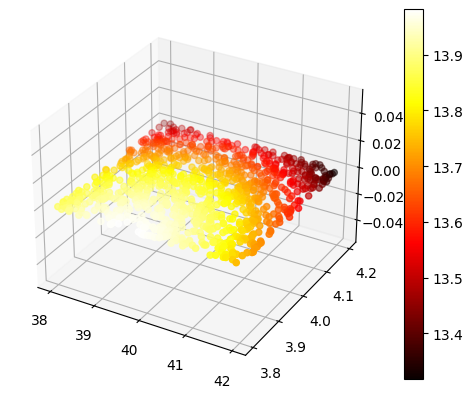

In [752]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_m = np.random.uniform(38,42, 1000)
y_m = np.random.uniform(3.8,4.2, 1000)
X, Y = np.meshgrid(x_m,y_m)
data=pd.DataFrame({'x':x_m, 'y':y_m})

c = res2.predict(data)
data['ypred']=c

#plt.contourf(x_t,y_t,Z, levels=10, vmin=0)
#plt.contourf(x_m, y_m, c, levels=10, vmin=0)
#plt.colorbar()
#plt.scatter(results_doe3.Temperature,results_doe3.Concentration, c='r')

img = ax.scatter(x_m, y_m, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()


In [753]:
data['ypred'].idxmax()
data.iloc[data['ypred'].idxmax()]

,421
x,39.810117
y,3.804928
ypred,13.981689


In [754]:
run_experiment(39.81, 3.804)

13.980724846277816